In [113]:
from tqdm import tqdm
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [114]:
def plot_freq(title, data):
    
    fig, ax = plt.subplots(figsize=(6,3))
    bars = ax.bar(['delayed' if x==1 else 'on time' for x in data[0]], data[1])

    ax.set_title(f'Class Instances in {title.capitalize()} Dataset')
    ax.set_xlabel('Count')
    ax.set_ylabel('Labels')

    ax.bar_label(bars, data[1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the chart
    plt.show()

# samples after dropping nan: 9480
train:
<class 'numpy.float64'>
 - Number of features:  5
 - Number of samples:  6636


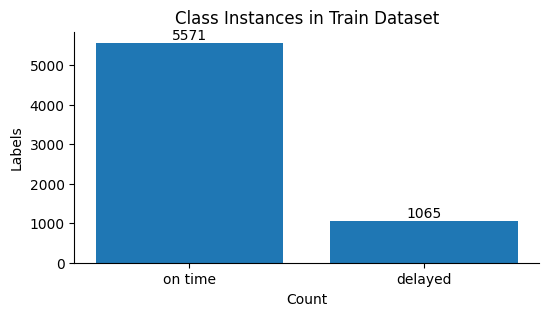


test:
<class 'numpy.float64'>
 - Number of features:  5
 - Number of samples:  1422


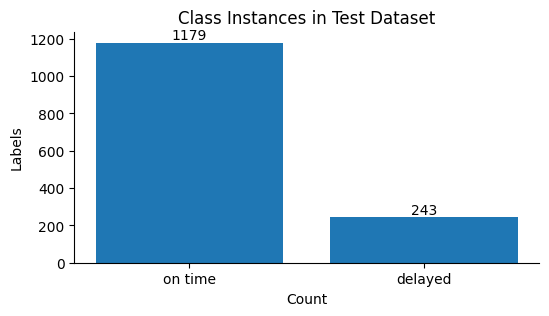


validation:
<class 'numpy.float64'>
 - Number of features:  5
 - Number of samples:  1422


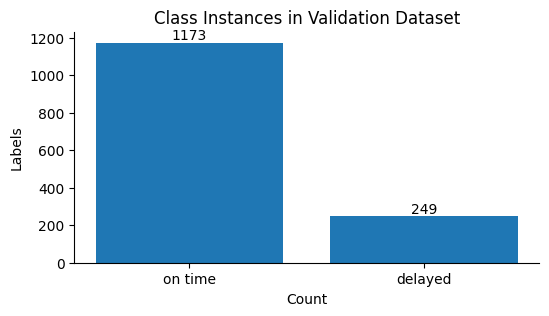

In [115]:
# read in data
# NOTE change your file path
master_df = pd.read_csv('../../raw/Flights_2018_1.csv',
                nrows=10000,
                low_memory=False # TODO not sure what this does
                )
feature_cols = ["DayofMonth","Month","Year", "Distance","DepDelay", "ArrDel15", "Operating_Airline "]
df = master_df[feature_cols].dropna() # get rid of nan

'''
process data for training, split into test/train/validation
'''

# NOTE remove operating airline if not using one hot encoding
# X = df[["DayofMonth","Month","Year", "Distance", "DepDelay", "Operating_Airline "]]
X = df[["DayofMonth","Month","Year", "Distance", "DepDelay"]]
y = df[["ArrDel15"]]
y = y.ArrDel15.ravel() # flatten

print("# samples after dropping nan:", y.shape[0])

# split into train and test/validation (which is split in next line)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=150)

# create validation and test sets each 15% of total data
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val, y_test_val,
                                                    test_size=0.5,
                                                    random_state=150)
d = {"train": (X_train,y_train), "test":(X_test,y_test), "validation": (X_validation,y_validation)}


# number of classes, number of instances in each class
for each in d.keys():
    print(f"{each}:")
    print(type(d[each][1][0]))
    print(" - Number of features: ", len(d[each][0].columns))
    print(" - Number of samples: ", len(d[each][0]))
    unique, counts = np.unique(d[each][1], return_counts=True)
    plot_freq(each, (unique, counts))
    print()


In [116]:
'''
One hot encoding, create column transform which gets added to pipeline
'''
# onehot_cols = ['Month', 'Operating_Airline ']
# col_transf = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), onehot_cols)], remainder='passthrough')

# NOTE get feature names by uncommenting the following: 
# col_transf.fit(X_train, y_train)
# print(col_transf.get_feature_names_out())

'\nOne hot encoding, create column transform which gets added to pipeline\n'

In [117]:
# create train numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_validation = X_validation.to_numpy()

# TODO test/train/validation split

# encode string genres -> integers
# classes = genre_encoding(train["genre"]) # create label encoding for classes
# y_train = genre_encode(train["genre"]) # encode classes -> integer array
# y_test = genre_encode(test["genre"])
# y_valid = genre_encode(validation["genre"])

# convert to tensors
X_train, y_train, X_test, y_test, X_validation, y_validation = map(
    torch.tensor, (X_train, y_train, X_test, y_test, X_validation, y_validation)
)

In [118]:
# create model including fit and score methods
class FeedForward(nn.Module):
    def __init__(self, num_hidden_layers, num_nodes:int, num_features, num_classes) -> None:
        self.num_classes = num_classes
        super(FeedForward, self).__init__()
        if num_hidden_layers == 1:
             self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_features, num_nodes),
                nn.ReLU(),
                nn.Linear(num_nodes, num_classes),
                nn.ReLU()
            )
        else:
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_features, num_nodes),
                nn.ReLU(),
                nn.Linear(num_nodes, num_nodes),
                nn.ReLU(),
                nn.Linear(num_nodes, num_classes),
                nn.ReLU()
            )

    def forward(self, xb):
        xb = xb.to(self.layers[1].weight.dtype)
        return self.layers(xb)
        
    def fit(self, train_dataset: TensorDataset, validation_dataset: TensorDataset, batch_size: int, 
            epochs: int, loss_function, learning_rate: float):
        
        # create dataloader for batching, shuffle to avoid overfitting/batch correlation
        train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
        valid_dl = DataLoader(validation_dataset, batch_size, shuffle=True)

        # opt = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=.9, weight_decay=.0000001) # create optimizer TODO weight decay
        opt = torch.optim.SGD(self.parameters(), lr=learning_rate) # create optimizer TODO weight decay

        # store epoch losses
        training_losses = []
        validation_losses = []

        for epoch in tqdm(range(epochs)):
            self.train()
            epoch_training_loss = 0
            epoch_validation_loss = 0

            for xb, yb in train_dl:
                # run model on batch and get loss
                predictions = self(xb)
                loss = loss_function(predictions, yb.to(torch.int64))

                # Back Propagation
                loss.backward()  # compute gradient
                opt.step()       # update weights
                opt.zero_grad()  # reset gradient

            self.eval()
            with torch.no_grad():
                for xb_tr, yb_tr in train_dl:
                    # train loss
                    train_predictions = self(xb_tr)
                    training_loss = loss_function(train_predictions, yb_tr.to(torch.int64))
                    epoch_training_loss += (training_loss * xb_tr.shape[0]) # NOTE changed batch size
                for xb_val, yb_val in valid_dl:
                    # val loss
                    val_predictions = self(xb_val)
                    validation_loss = loss_function(val_predictions, yb_val.to(torch.int64)) # get loss
                    epoch_validation_loss += (validation_loss * xb_val.shape[0]) # NOTE changed batch size
                # get epoch loss
                num_train_samples = len(train_dataset)
                epoch_training_loss_normalized = epoch_training_loss / num_train_samples 
                training_losses.append(epoch_training_loss_normalized.item())

                num_val_samples = len(validation_dataset)
                epoch_validation_loss_normalized = epoch_validation_loss / (num_val_samples) 
                validation_losses.append(epoch_validation_loss_normalized.item())

        return training_losses, validation_losses

    def score(self, tensor_dataset: TensorDataset, batch_size=1) -> float:
        # reference: https://blog.paperspace.com/training-validation-and-accuracy-in-pytorch/
        self.eval()
        dataloader = DataLoader(tensor_dataset, batch_size, shuffle=True)
        all_predictions = torch.tensor([],dtype=torch.long)
        ground_truth_labels = torch.tensor([],dtype=torch.long)
        with torch.no_grad():
            for xb, yb in tqdm(dataloader):
                # run model on batch
                class_probabilities = self(xb)

                # choose most likely class for each sample from probabilities
                predictions = torch.argmax(class_probabilities, dim=1)
                # create running tensor with all true_label, predicted_label pairs 
                ground_truth_labels = torch.cat((ground_truth_labels, yb))
                all_predictions = torch.cat((all_predictions, predictions))
            
            # create a stack where the top layer is the ground truth, bottom is prediction
            true_pred_stack = torch.stack((ground_truth_labels, all_predictions))
            
            class_accuracy = {i:0 for i in range(self.num_classes)} # dictionary containing class accuracies
            for label in range(self.num_classes):
                # get all pairs with the same true label in the tensor stack
                class_pairs = list(filter(lambda pair: pair[0] == label, true_pred_stack.T)) 

                # calculate how many have correctly been predicted (true = predicted)
                num_correct = len(list(filter(lambda pair: pair[0] == pair[1], class_pairs)))

                # find accuracy
                class_accuracy[label] = num_correct/len(class_pairs)

            # TODO GET RID of this, it's leftover from hw4
            # transform int labels to their corresponding string label
            # class_accuracy_labeled = {genre_decode([key])[0]:class_accuracy[key] for key in class_accuracy.keys()}

            # get mean accuracy
            correct = sum(all_predictions == ground_truth_labels).item()
            mean_accuracy = correct / len(tensor_dataset)
            
            return mean_accuracy, class_accuracy
                

In [119]:
# create model including fit and score methods
class FeedForward(nn.Module):
    def __init__(self, num_hidden_layers, num_nodes:int, num_features, num_out) -> None:
        self.num_classes = num_out
        super(FeedForward, self).__init__()
        if num_hidden_layers == 1:
             self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_features, num_nodes),
                nn.ReLU(),
                nn.Linear(num_nodes, num_out),
                nn.ReLU()
            )
        else:
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_features, num_nodes),
                nn.ReLU(),
                nn.Linear(num_nodes, num_nodes),
                nn.ReLU(),
                nn.Linear(num_nodes, num_out),
                nn.ReLU()
            )

    def forward(self, xb):
        xb = xb.to(self.layers[1].weight.dtype)
        return self.layers(xb)
        
    def fit(self, train_dataset: TensorDataset, validation_dataset: TensorDataset, batch_size: int, 
            epochs: int, loss_function, learning_rate: float):
        
        # create dataloader for batching, shuffle to avoid overfitting/batch correlation
        train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
        valid_dl = DataLoader(validation_dataset, batch_size, shuffle=True)

        # opt = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=.9, weight_decay=.0000001) # create optimizer TODO weight decay
        # TODO tune optimizer
        # opt = torch.optim.SGD(self.parameters(), lr=learning_rate) # create optimizer TODO weight decay
        opt = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # store epoch losses
        training_losses = []
        validation_losses = []

        for epoch in tqdm(range(epochs)):
            self.train()
            epoch_training_loss = 0
            epoch_validation_loss = 0

            for xb, yb in train_dl:
                # run model on batch and get loss
                predictions = self(xb)
                print(predictions)
                loss = loss_function(predictions, yb.to(torch.int64))

                # Back Propagation
                loss.backward()  # compute gradient
                opt.step()       # update weights
                opt.zero_grad()  # reset gradient

            self.eval()
            with torch.no_grad():
                for xb_tr, yb_tr in train_dl:
                    # train loss
                    train_predictions = self(xb_tr)
                    training_loss = loss_function(train_predictions, yb_tr.to(torch.int64))
                    epoch_training_loss += (training_loss * xb_tr.shape[0]) # NOTE changed batch size
                for xb_val, yb_val in valid_dl:
                    # val loss
                    val_predictions = self(xb_val)
                    validation_loss = loss_function(val_predictions, yb_val.to(torch.int64)) # get loss
                    epoch_validation_loss += (validation_loss * xb_val.shape[0]) # NOTE changed batch size
                # get epoch loss
                num_train_samples = len(train_dataset)
                epoch_training_loss_normalized = epoch_training_loss / num_train_samples 
                training_losses.append(epoch_training_loss_normalized.item())

                num_val_samples = len(validation_dataset)
                epoch_validation_loss_normalized = epoch_validation_loss / (num_val_samples) 
                validation_losses.append(epoch_validation_loss_normalized.item())

        return training_losses, validation_losses

    def score(self, tensor_dataset: TensorDataset, batch_size=1) -> float:
        # reference: https://blog.paperspace.com/training-validation-and-accuracy-in-pytorch/
        self.eval()
        dataloader = DataLoader(tensor_dataset, batch_size, shuffle=True)
        all_predictions = torch.tensor([],dtype=torch.long)
        ground_truth_labels = torch.tensor([],dtype=torch.long)
        with torch.no_grad():
            for xb, yb in tqdm(dataloader):
                # run model on batch
                class_probabilities = self(xb)

                # choose most likely class for each sample from probabilities
                predictions = torch.argmax(class_probabilities, dim=1)
                # create running tensor with all true_label, predicted_label pairs 
                ground_truth_labels = torch.cat((ground_truth_labels, yb))
                all_predictions = torch.cat((all_predictions, predictions))
            
            # create a stack where the top layer is the ground truth, bottom is prediction
            true_pred_stack = torch.stack((ground_truth_labels, all_predictions))
            
            class_accuracy = {i:0 for i in range(self.num_classes)} # dictionary containing class accuracies
            for label in range(self.num_classes):
                # get all pairs with the same true label in the tensor stack
                class_pairs = list(filter(lambda pair: pair[0] == label, true_pred_stack.T)) 

                # calculate how many have correctly been predicted (true = predicted)
                num_correct = len(list(filter(lambda pair: pair[0] == pair[1], class_pairs)))

                # find accuracy
                class_accuracy[label] = num_correct/len(class_pairs)

            # TODO GET RID of this, it's leftover from hw4
            # transform int labels to their corresponding string label
            # class_accuracy_labeled = {genre_decode([key])[0]:class_accuracy[key] for key in class_accuracy.keys()}

            # get mean accuracy
            correct = sum(all_predictions == ground_truth_labels).item()
            mean_accuracy = correct / len(tensor_dataset)
            
            return mean_accuracy, class_accuracy
                

In [120]:
# create dataset and dataloader
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
valid_ds = TensorDataset(X_validation, y_validation)

In [121]:
loss_function = nn.CrossEntropyLoss()
num_features = X_train.shape[1]
classes = y_train.unique()

In [122]:
# exhaustive hyperparameter tuning based on the best final validation loss
def ffn_tune(num_hidden_layers, num_nodes):
    params = {"bs":(64,),
                "epoch":(50,),
                "learning_rate":(.01,)}
    # params = {"bs":(50, 64, 80),
    #             "epoch":(30,50),
    #             "learning_rate":(.008,.09)}
    # params = {"bs":(30,),
    #             "epoch":(50,),
    #             "learning_rate":(.01, .05, .09, .1, .3, .5)}
    best_model = {key:params[key] for key in params}
    best_model["best_loss"] = 100000000000
    for bs in params["bs"]:
        for epoch in params["epoch"]:
            for lr in params["learning_rate"]:
                # use validation loss
                model = FeedForward(num_hidden_layers, num_nodes, num_features, len(classes))
                training_losses, valid_losses = model.fit(train_ds, valid_ds, bs, epoch, loss_function, lr)
                if valid_losses[-1] < best_model["best_loss"]:
                    best_model["model"]=model
                    best_model["best_loss"] = valid_losses[-1]
                    best_model["epoch"] = epoch
                    best_model["learning_rate"] = lr
                    best_model["bs"] = bs
                    best_model["valid_losses"] = valid_losses
                    best_model["training_losses"] = training_losses
                print("best loss: ",best_model["best_loss"])
    return best_model


In [125]:
def ffn_evaluate(model):
# plot losses
    plt.plot(model["training_losses"], label="Training Loss")
    print(model["training_losses"])
    plt.plot(model["valid_losses"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # calculate accuracy
    d = {"train": train_ds, "test": test_ds, "validation": valid_ds}
    for dataset in d:
        print(f"Evaluating **{dataset}** dataset:")
        mean_accuracy, class_accuracy = model["model"].score(d[dataset], model["bs"])
        print(f"Mean Accuracy: {mean_accuracy*100:.3f}")
        print(f"Mean per-class accuracy:")
        print(class_accuracy)
        for key in class_accuracy:
            print(f"  {'delayed' if key==1 else 'on time'}{': '}{class_accuracy[key]*100:.3f}%")
        print()

64 Nodes, 1 Hidden Layer(s)


  2%|▏         | 1/50 [00:00<00:05,  8.57it/s]

tensor([[170.3525,   0.0000],
        [180.2434,   0.0000],
        [367.4982,   0.0000],
        [213.7131,   0.0000],
        [186.2804,   0.0000],
        [181.8248,   0.0000],
        [165.9205,   0.0000],
        [173.8587,   0.0000],
        [214.1994,   0.0000],
        [210.1121,   0.0000],
        [190.0779,   0.0000],
        [207.8118,   0.0000],
        [311.8295,   0.0000],
        [170.7198,   0.0000],
        [189.6642,   0.0000],
        [177.9607,   0.0000],
        [231.1025,   0.0000],
        [183.6567,   0.0000],
        [426.1333,   0.0000],
        [216.8127,   0.0000],
        [178.6002,   0.0000],
        [181.6850,   0.0000],
        [187.6305,   0.0000],
        [182.0020,   0.0000],
        [219.8651,   0.0000],
        [177.5751,   0.0000],
        [187.0786,   0.0000],
        [194.4129,   0.0000],
        [219.3858,   0.0000],
        [175.9680,   0.0000],
        [191.9887,   0.0000],
        [176.5562,   0.0000],
        [214.4676,   0.0000],
        [1

  6%|▌         | 3/50 [00:00<00:05,  8.70it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 10%|█         | 5/50 [00:00<00:04,  9.05it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 14%|█▍        | 7/50 [00:00<00:04,  9.06it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 16%|█▌        | 8/50 [00:00<00:04,  9.06it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 20%|██        | 10/50 [00:01<00:04,  8.81it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 24%|██▍       | 12/50 [00:01<00:04,  8.99it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 28%|██▊       | 14/50 [00:01<00:04,  8.72it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 32%|███▏      | 16/50 [00:01<00:03,  8.94it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 36%|███▌      | 18/50 [00:02<00:03,  9.03it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 40%|████      | 20/50 [00:02<00:03,  8.89it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 42%|████▏     | 21/50 [00:02<00:03,  8.94it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 46%|████▌     | 23/50 [00:02<00:03,  8.65it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 50%|█████     | 25/50 [00:02<00:02,  8.92it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 54%|█████▍    | 27/50 [00:03<00:02,  8.95it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 58%|█████▊    | 29/50 [00:03<00:02,  9.05it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 62%|██████▏   | 31/50 [00:03<00:02,  9.02it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 64%|██████▍   | 32/50 [00:03<00:01,  9.02it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 68%|██████▊   | 34/50 [00:03<00:01,  8.86it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 72%|███████▏  | 36/50 [00:04<00:01,  8.65it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 76%|███████▌  | 38/50 [00:04<00:01,  8.87it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 80%|████████  | 40/50 [00:04<00:01,  8.79it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 84%|████████▍ | 42/50 [00:04<00:00,  8.40it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 88%|████████▊ | 44/50 [00:04<00:00,  8.48it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 92%|█████████▏| 46/50 [00:05<00:00,  8.38it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 94%|█████████▍| 47/50 [00:05<00:00,  8.41it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

 98%|█████████▊| 49/50 [00:05<00:00,  7.80it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

100%|██████████| 50/50 [00:05<00:00,  8.73it/s]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

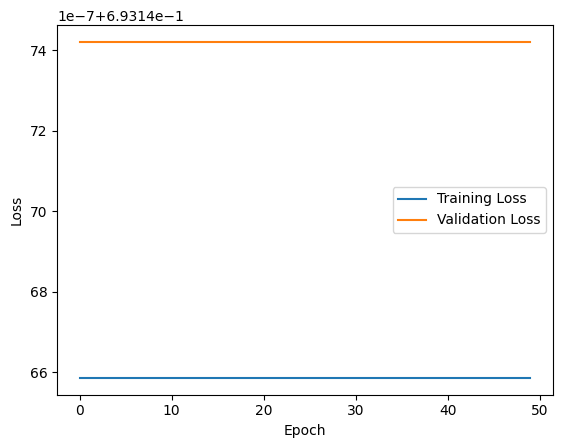

Evaluating **train** dataset:


100%|██████████| 104/104 [00:00<00:00, 3958.87it/s]


Mean Accuracy: 83.951
Mean per-class accuracy:
  on time: 100.000%
  delayed: 0.000%

Evaluating **test** dataset:


100%|██████████| 23/23 [00:00<00:00, 4027.93it/s]


Mean Accuracy: 82.911
Mean per-class accuracy:
  on time: 100.000%
  delayed: 0.000%

Evaluating **validation** dataset:


100%|██████████| 23/23 [00:00<00:00, 1940.25it/s]

Mean Accuracy: 82.489
Mean per-class accuracy:
  on time: 100.000%
  delayed: 0.000%



In [126]:
# run model tuning and evaluation on the 4 combos of layers/nodes
def tune_FF(num_layers: int, num_nodes: int):
    print(f"{num_nodes} Nodes, {num_layers} Hidden Layer(s)")
    model = ffn_tune(num_layers,num_nodes)
    print("best batch size: ", model["bs"])
    print("best epoch: ", model["epoch"])
    print("best learning rate: ", model["learning_rate"])
    ffn_evaluate(model)

# for pair in [(1,64),(2,64),(1,128),(2,128)]:
tune_FF(1,64)
